In [3]:
# from lfs_tree import *
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import pydot
import networkx as nx
from string import Template
import pandas as pd
import glob
import pydot
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import seaborn as sns

from IPython.display import Image, display
import matplotlib.pyplot as plt
# from IPython.display import Image, display
import pickle

In [2]:
# functions

def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

def show_trees(directory):
    for f in glob.glob(f'{directory}*tree_*'):
        file = open(f)
        dot_string = file.read()
        print(f)
#             print(dot_string)
        graph = pydot.graph_from_dot_data(dot_string)[0]
        view_pydot(graph)
        print('\n')
            
def show_stats(directory):
    results_files = []
    unsuccessful_cnt = 0
    fs = glob.glob(f'{directory}/**/')
    for f in fs:
        passed_strats = glob.glob(f'{f}**/')
        if(len(passed_strats)==3):
            for ps in passed_strats:
                results_files.append(pd.read_csv(ps+'experiment_stats'))
        else:
            unsuccessful_cnt+=1
    df = pd.concat(results_files)
    print(f"unsuccessful cnt : {unsuccessful_cnt}")
    return df

def determine_shape(x, shape_assignment_dict):
    return shape_assignment_dict[x]

def determine_color(x, color_assignment_dict):
    return color_assignment_dict[x]

def scatter_plots(df, x, y, xlabel, ylabel, title, shape_assignment_dict, color_assignment_dict,
                 first_legend_pos, second_legend_pos, strat_legend_rel_pos, ratio_legend_re_pos):
        
    fig, ax = plt.subplots()
    groups = df.groupby(['strat','complaint_ratio'])
    # Create a scatter plot for each group based on shape and color
    for (strat, ratio), group in groups:
        marker = shape_assignment_dict.get(strat)
        color=color_assignment_dict.get(ratio)
        ax.scatter(group[x], group[y], marker=marker, color=color, label=(strat, ratio))

    # Create separate shape and color legends
    legend_elements_1 = []
    legend_elements_2 = []

    for shape, marker in shape_assignment_dict.items():
        legend_elements_1.append(plt.Line2D([0], [0], marker=marker, color='w', label=shape, markerfacecolor='k'))
    for ratio, color in color_assignment_dict.items():
        legend_elements_2.append(plt.Line2D([0], [0], marker='o', color='w', label=ratio, markerfacecolor=color))

    # Add shape and color legends
    first_legend=ax.legend(handles=legend_elements_1, loc=first_legend_pos, 
                           bbox_to_anchor=strat_legend_rel_pos,
                           title='strategy', 
                           fontsize=13,title_fontsize=14)
    ax.legend(handles=legend_elements_2, loc=second_legend_pos, 
              bbox_to_anchor=ratio_legend_re_pos, title='complaint%',
              fontsize=13, title_fontsize=14)

    ax.add_artist(first_legend)

    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=14)

    plt.show()
    plt.close(fig)
    

def scatter_plot_single_group_value(df, x, y, xlabel, ylabel, title, color_assignment_dict, group_col,
                                   scale, xticks=[], yticks=[]):
    fig, ax = plt.subplots()
    groups = df.groupby([group_col])
    for (g), group in groups:
        color = color_assignment_dict.get(g)
        ax.scatter(group[x], group[y], color=color, label=(g), s=20)  # Set linestyle to an empty string
    if(ylabel=='new_global_accuracy'):
        ax.plot(df[x], df['global_accuracy'], color='black', label='accuracy_before_fix')
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=14)
    ax.set_yscale(scale)  # Set the y-axis to logarithmic scale
    if(yticks):
        ax.set_yticks(yticks)
    if(xticks):
        ax.set_xticks(xticks)
    # Customize y-axis ticks and labels
#     ax.set_yticks([0.1, 1, 10, 100])
#     ax.set_yticklabels(['10^-1', '10^0', '10^1', '10^2'])
    ax.legend(fontsize=13,title_fontsize=14)
    plt.savefig(f'graph_pdfs/{title}.pdf', format='pdf')
    
    plt.show()
    plt.close(fig)
    plt.show()
    plt.close(fig)

    
def line_plots(df, x, y, xlabel, ylabel, title, color_assignment_dict, legend_pos,
#                group_name,
#                group_value, 
               gtype='general',
               ylim=None,
              ):
    fig, ax = plt.subplots()
#     df=df[df[group_name]==group_value]
    # Create a scatter plot for each group based on shape and color
    groups = df.groupby(['strat'])
    for strat, group in groups:
        color = color_assignment_dict.get(strat)
        print(f'color: ')
        ax.plot(group[x], group[y], color=color, label=strat)
    if(gtype=='accuracy'):
        ax.plot(df[x], df['global_accuracy'], color='blue', label='accuracy_before_fix')
    ax.legend()
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=14)
    if(ylim):
        ax.set_ylim(ylim)
    plt.savefig(f'graph_pdfs/{title}.pdf', format='pdf')
    plt.show()
    plt.close(fig)


def boxplot(df, x, y, xlabel, ylabel, title, yscale=[], xscale=[], yticks=[], xticks=[]):
    plt.figure(figsize=(8, 6))
    
    # Set the y-axis scale
    strat_list = list(df['strat'].unique())
    strat_list.sort()
    
    if(y=='rbbm_runtime' or y=='avg_tree_size_increase'):
        ax=sns.swarmplot(data=df, x=x, y=y, hue='strat', hue_order=strat_list)
    else:
        ax = sns.boxplot(data=df, x=x, y=y, hue='strat', hue_order=strat_list)
        # Change tick label font size for both x and y axes
        
#     ax = sns.boxplot(data=df, x=x, y=y, hue='strat', hue_order=strat_list)
        # Change tick label font size for both x and y axes
    ax.tick_params(axis='both', labelsize=12)
    
    # Add a horizontal line at the specified y-coordinate (line_y)
    if ylabel == 'new_global_accuracy':
#     if line_y is not None:
        ax.axhline(y=float(df['global_accuracy'].mean()), color='red', label='gloabl accuracy before fix',
                  linewidth=5)
        ax.legend(fontsize=14,title_fontsize=15)
        # Create a separate legend for the box plot (customize as needed)
        box_legend = ax.legend(title='Strat',fontsize=13,title_fontsize=15)
    
        # Combine the legends
        ax.add_artist(box_legend)
    else:
        # Create a separate legend for the box plot (customize as needed)
        ax.legend(title='Strat',fontsize=14,title_fontsize=15)
    if yscale:
        ax.set_yscale(yscale)
    
    if xscale:
        ax.set_xscale(xscale)
    
    if yticks:
        ax.set_yticks(yticks)
    
    if xticks:
        ax.set_xticks(xticks)

    plt.title(title,fontsize=20)
    plt.xlabel(xlabel,fontsize=14)
    plt.ylabel(ylabel,fontsize=14)

    plt.savefig(f"graph_pdfs/box_{title}.pdf", format="pdf")
    plt.show()



In [18]:
with open('../experiment_results_folders/retrain_every_x_percent/\
_20231013002756/20231013002756retrain_bookkeeping_dict.pkl', 'rb') as hf:
    fix_history_dict = pickle.load(hf)

with open('../experiment_results_folders/retrain_every_x_percent\
/_20231013004526/20231013004526_retrain_bookkeeping_dict.pkl', 'rb') as hf2:
    fix_history_dict_320 = pickle.load(hf2)
        

In [20]:
data = pd.DataFrame(fix_history_dict)
data_320 = pd.DataFrame(fix_history_dict_320)

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def retrain_every_x_percent_graph(data):
    # Create a figure and define the left and right axes
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.plot(data['number_of_funcs_fixed'], data['fix_rate'], label='fix_rate', color='b', marker='o')
    ax1.plot(data['number_of_funcs_fixed'], data['confirm_preserve_rate'], label='confirm_preserve_rate', color='g', marker='o')
    ax1.plot(data['number_of_funcs_fixed'], data['new_global_accuracy'], label='new_global_accuracy', color='r', marker='o')

    ax2.plot(data['number_of_funcs_fixed'], data['avg_tree_size_increase'], label='avg_tree_size_increase', color='c', marker='o')

    ax1.set_xlabel('number_of_funcs_fixed')
    ax1.set_ylabel('Fix Rate / Confirm Preserve Rate / New Global Accuracy', color='black')
    ax2.set_ylabel('Average Tree Size Increase', color='black')

    plt.title('retrain every 10% of rules')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines = lines1 + lines2
    labels = labels1 + labels2

    # Add a legend
    ax1.legend(lines, labels, loc='upper left')

    # Show the plot
    plt.show()


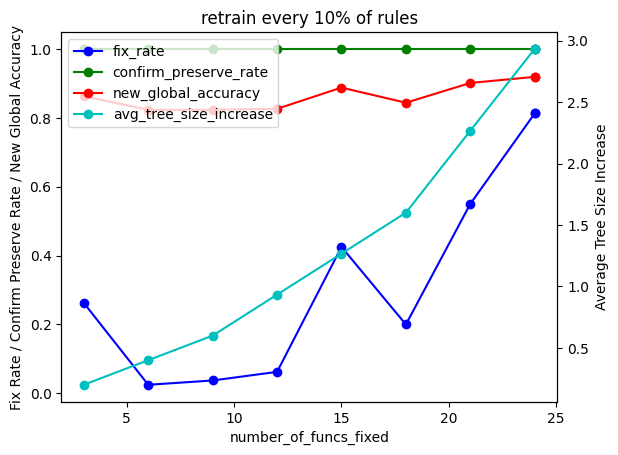

In [21]:
retrain_every_x_percent_graph(data)

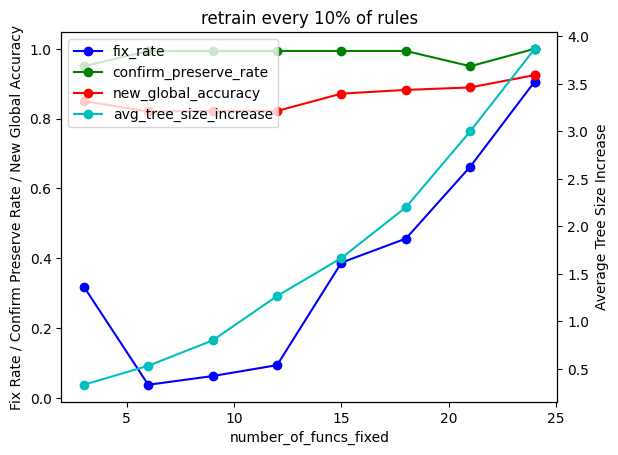

In [22]:
retrain_every_x_percent_graph(data_320)